## Final Task:
This is your final evaluation for the project. As decided, we will be predicting images of people into three classes: `without_mask`, `mask_weared_incorrect` and `with_mask`. 

In [28]:
import tensorflow as tf

### Loading the dataset
Make a copy of the dataset given to you in your Google Drive (keep it outside, don't put it in any folder to avoid inconvenience). Ensure it is named as `Mask_Dataset` or change the path (the variable `data_dir`) accordingly.

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import pathlib

path='/content/drive/MyDrive/Mask_Dataset/'
data_dir = pathlib.Path(path)

### Know the Dataset
Most of the code is written for you as you aren't used to these libraries. You are to go through the documentation for your benefit.

In [31]:
# Print image count
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

8982


In [32]:
# Print Output Labels
import os
output_classes = os.listdir(data_dir)
print(output_classes)

['without_mask', 'mask_weared_incorrect', 'with_mask']


[2994, 2994, 2994]


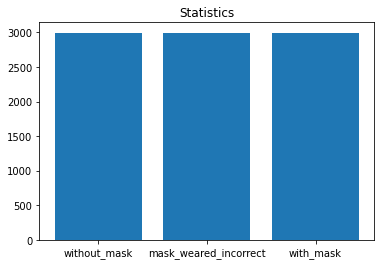

In [33]:
# Plot count of each ouput label
import matplotlib.pyplot as plt

count=[]
for label in output_classes:
  this_path=path+label
  dir=pathlib.Path(this_path)
  im_count=os.listdir(dir)
  count.append(len(im_count))

print(count)

plt.bar(output_classes,count)
plt.title("Statistics")
plt.show()

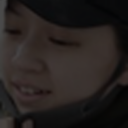

In [36]:
# Check some sample images (Use of cv2)
import cv2
from google.colab.patches import cv2_imshow
img= cv2.imread("/content/drive/MyDrive/Mask_Dataset/mask_weared_incorrect/1004.png")
cv2_imshow(img)

# Your code

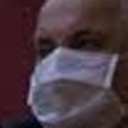

In [53]:
img= cv2.imread("/content/drive/MyDrive/Mask_Dataset/with_mask/1003.png")
cv2_imshow(img)

In [38]:

img2=cv2.imread('/content/drive/MyDrive/Mask_Dataset/mask_weared_incorrect/1008.png') 
img2.shape
# Check shape of the images in your dataset. This will be helpful while specifying input_shape in your Transfer Learning Model

(128, 128, 3)

In [39]:
# Check if all the images have same shape, else you need to resize them to some common size
# The code provided as it is above in the template will help
flag=False
pixel=(128,128,3) 

for label in output_classes:
  this_path=path+label
  dir=pathlib.Path(this_path)
  im_count=os.listdir(dir)
  for i in range(len(im_count)):
    image = this_path+'/'+im_count[i] 
    testing=cv2.imread(image)
    if testing.shape!=pixel:
      flag=True

if(flag==True):
  print(" all images have not same size")
else:
  print(" all images have the same size") 

 all images have the same size


In [ ]:
# If the shape is variable, reshape to a common size 
# If it is same, prove it

In [ ]:
# Anything else you want to plot/experiment

### Model Definition
Choose a model for Transfer Learning (You may also experment with multiple models and keep all of them in this notebook)

In [15]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [16]:
# Choose and define base model
base_model = keras.applications.ResNet50(
    weights="imagenet", 
    include_top=False, # Do not include the ImageNet classifier/ fully connected layer at the top.
)

In [17]:
base_model.summary()
# Print base model summary and have a look at the layers

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [18]:
base_model.trainable= False
# As we're using Transfer Learning, you do not need to train all the layers. Freeze all of the layers or train some layers (experiment)

In [20]:
# Append Fully connected/custom Conv2D/Dropout/MaxPooling layers to the base model
IMG_SIZE=(128,128,3)
inputs = keras.Input(shape=IMG_SIZE)
x = inputs
x = base_model(x, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512)(x)
x = keras.layers.Dropout(0.2)(x)

In [21]:
# Add the final output layer
outputs = keras.layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               16777728  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 40,366,979
Trainable params: 16,779,267
Non-t

In [22]:
# Compile you model (set the parameters like loss/optimizers/metrics)

model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


### Data Augmentation and Pre-processing
Augment the data. You may also try dyanamic augmentation using [`tf.keras.preprocessing.image.ImageDataGenerator `](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).   
You may use [`tf.keras.applications.vgg16.preprocess_input`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input)(or some other base model's utility) for pre-processing (can also be passed as a parameter to `ImageDataGenerator`)

In [51]:
#from keras.applications.vgg16 import preprocess_input # Change according to your base model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data_gen=ImageDataGenerator(
      
      fill_mode='nearest',
      width_shift_range=0.4,
      zoom_range=0.5,
      rescale=1./255,
      horizontal_flip=True,
      rotation_range=20,
      height_shift_range=0.4,
      shear_range=0.2,
      validation_split=0.4,
)


# Your code  shear_range=0.2, zoom_range = 0.2

### Training and Validation Dataset  
Split the dataset into training and validation (We'll be looking for your validation accuracy, assume we are using complete dataset for now). 

Hint: `flow_from_directory` used with `ImageDataGenerator` will simplify things for you.

In [41]:
# Your code
train_generator = train_data_gen.flow_from_directory(
    directory=path,
    target_size=(128,128),
    color_mode='rgb',
    subset="training",
    class_mode='categorical',
    batch_size=64)
validation_generator = train_data_gen.flow_from_directory(
    directory=path,
    target_size=(128,128),
    color_mode='rgb',
    subset="validation",
    class_mode='categorical',
    batch_size=64)

Found 5391 images belonging to 3 classes.
Found 3591 images belonging to 3 classes.


### Training  
Train your model for some epochs and plot the graph. Try and save your best model. Experiment with the parameters of `model.fit`

In [ ]:
from keras.callbacks import ModelCheckpoint
# ModelCheckpoint is helpful to save the model giving best results (brownie points)
#model.fit(train_generator, validation_generator, epochs = 1)
history = model.fit(train_generator, validation_data=validation_generator, epochs=10)

### Evaluate the performance

In [ ]:
# Plot training & validation loss/accuracy values


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# print classification report

In [ ]:
# Use the classification report to print precision, recall, f1-score for the three classes(optional, brownie points)